In [36]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

from sklearn.model_selection import train_test_split


# import from scipy solve_ivp
from scipy.integrate import solve_ivp
import torch
%matplotlib widget

from ray import train, tune
from ray.train import Checkpoint, session, report
from ray.tune.schedulers import ASHAScheduler

import os
import tempfile

In [94]:
path = os.getcwd()
results_dir = os.path.join(path, "../tuning")
os.makedirs(results_dir, exist_ok=True)

# Tuning of the PINN for the Damped Harmonic Oscillator ODE

In this notebook we tune the hyperparamenters of the PINN.

## Load data

In [38]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/DHOscillator_data.npy')
data_X = data[:,0]
data_Y = data[:,1:]

In [39]:
def data_loader(X, Y, batch_size):
    """
    Function to load data and divide it in batches
    input: X, Y, batch_size
    output: train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    """

    # divide in train, validation and test
    train_frac = 0.7
    val_frac = 0.15
    test_frac = 0.15

    train_val_X = X[:int((train_frac+val_frac)*len(X))]
    train_val_Y = Y[:int((train_frac+val_frac)*len(X)), :]
    train_X, val_X, train_Y, val_Y = train_test_split(
        train_val_X, 
        train_val_Y, 
        test_size=val_frac/(train_frac+val_frac), 
        random_state=42
        )

    test_X = X[int((train_frac+val_frac)*len(X)):]
    test_Y = Y[int((train_frac+val_frac)*len(X)):, :]

    # convert to torch tensor
    train_X = torch.tensor(train_X, dtype=torch.float32).view(-1, 1)
    train_Y = torch.tensor(train_Y, dtype=torch.float32)
    val_X = torch.tensor(val_X, dtype=torch.float32).view(-1, 1)
    val_Y = torch.tensor(val_Y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32).view(-1, 1)
    test_Y = torch.tensor(test_Y, dtype=torch.float32)

    # divide in batches train
    train_X_batches = torch.split(train_X, batch_size)
    train_Y_batches = torch.split(train_Y, batch_size)

    
    return train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y

## Define hyper model

In [40]:
#  define the model
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 2))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

## Define the Objective

In [41]:
def objective(config):
    net = FFNN(config["n_layers"], config["n_neurons"])

    device = "cpu"

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        factor=config["factor"], 
        patience=config["patience"]
    )

    train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(data_X, data_Y, config["batch_size"])

    for epoch in range(50000):
        for i, (X, Y) in enumerate(zip(train_X_batches, train_Y_batches)):
            optimizer.zero_grad()
            Y_pred = net(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()
            optimizer.step()
            scheduler.step(loss)
            
        val_loss = criterion(net(val_X), val_Y).item()

        report(metrics={"loss": val_loss})

        if epoch % 100 == 0:
            torch.save(net.state_dict(), "./model.pth")

## Tuning

In [42]:
# configuration space and sampling method
config = {
    "n_layers": tune.randint(1, 5),
    "n_neurons": tune.randint(10, 50),
    "lr" : tune.loguniform(1e-4, 1e-1),
    "factor": tune.uniform(0.1, 0.9),
    "patience": tune.randint(100, 1000),
    "batch_size": tune.randint(32, 595)
}



# schedueler ASHA
scheduler = ASHAScheduler(
    metric="loss", 
    mode="min", 
    max_t=10000, 
    grace_period=2500, 
    reduction_factor=2
    )


tuner = tune.Tuner(
    objective,
    param_space=config,
    tune_config=tune.TuneConfig(
        num_samples=16,
        scheduler=scheduler,
    ),
    run_config=train.RunConfig(
        name="DHO_FFNN_tuning",
        storage_path=results_dir
    )
)

In [43]:
results = tuner.fit()

2024-03-10 21:00:02,695	INFO tune.py:1042 -- Total run time: 458.79 seconds (458.50 seconds for the tuning loop).


In [57]:
df = results.get_dataframe()
df

loss   timestamp checkpoint_dir_name  done  training_iteration  \
0   0.000061  1710100674                None  True               10000   
1   0.033320  1710100583                None  True               10000   
2   0.044591  1710100405                None  True                2500   
3   0.005030  1710100603                None  True               10000   
4   0.000005  1710100634                None  True               10000   
5   0.188000  1710100414                None  True                2500   
6   0.073328  1710100440                None  True                2500   
7   0.000062  1710100604                None  True               10000   
8   0.001768  1710100758                None  True                5000   
9   0.000910  1710100546                None  True                5000   
10  0.010280  1710100568                None  True                5000   
11  0.002539  1710100802                None  True                5000   
12  0.091638  1710100641                None  True                2500   
13  0.062574  1710100664                None  True                2500   
14  0.082134  1710100684                None  True                2500   
15  0.087197  1710100661                None  True                2500   

       trial_id                 date  time_this_iter_s  time_total_s    pid  \
0   b6cbc_00000  2024-03-10_20-57-54          0.015730    169.932873  10459   
1   b6cbc_00001  2024-03-10_20-56-23          0.021216     65.895605  10491   
2   b6cbc_00002  2024-03-10_20-53-25          0.011742     18.122798  10493   
3   b6cbc_00003  2024-03-10_20-56-43          0.010067     84.705609  10494   
4   b6cbc_00004  2024-03-10_20-57-14          0.016839    120.658826  10495   
5   b6cbc_00005  2024-03-10_20-53-34          0.010947     26.572859  10496   
6   b6cbc_00006  2024-03-10_20-54-00          0.024073     48.955651  10497   
7   b6cbc_00007  2024-03-10_20-56-44          0.010854     89.195537  10525   
8   b6cbc_00008  2024-03-10_20-59-18          0.039083    294.712348  10493   
9   b6cbc_00009  2024-03-10_20-55-46          0.008236     44.852540  10496   
10  b6cbc_00010  2024-03-10_20-56-08          0.007587     41.369596  10497   
11  b6cbc_00011  2024-03-10_21-00-02          0.027495    225.069007  10496   
12  b6cbc_00012  2024-03-10_20-57-21          0.013911     37.032490  10497   
13  b6cbc_00013  2024-03-10_20-57-44          0.017209     50.915546  10491   
14  b6cbc_00014  2024-03-10_20-58-04          0.013014     59.925988  10494   
15  b6cbc_00015  2024-03-10_20-57-41          0.008908     30.493110  10525   

    ...         node_ip time_since_restore  iterations_since_restore  \
0   ...  192.168.50.220         169.932873                     10000   
1   ...  192.168.50.220          65.895605                     10000   
2   ...  192.168.50.220          18.122798                      2500   
3   ...  192.168.50.220          84.705609                     10000   
4   ...  192.168.50.220         120.658826                     10000   
5   ...  192.168.50.220          26.572859                      2500   
6   ...  192.168.50.220          48.955651                      2500   
7   ...  192.168.50.220          89.195537                     10000   
8   ...  192.168.50.220         294.712348                      5000   
9   ...  192.168.50.220          44.852540                      5000   
10  ...  192.168.50.220          41.369596                      5000   
11  ...  192.168.50.220         225.069007                      5000   
12  ...  192.168.50.220          37.032490                      2500   
13  ...  192.168.50.220          50.915546                      2500   
14  ...  192.168.50.220          59.925988                      2500   
15  ...  192.168.50.220          30.493110                      2500   

    config/n_layers  config/n_neurons  config/lr  config/factor  \
0                 4                13   0.001922       0.208865   
1                 1                34   0.0009

In [65]:
def get_alive_model(df, max_epoch):
    """
    Function to get the number of alive models at each epoch
    input: df, max_epoch
    output: alive_model
    """
    # get traininig_iteration vector
    training_iteration = df["training_iteration"]
    training_iteration = training_iteration.to_numpy()
    # alive_model = number of entries of training_iteration > epoch
    # epoch = (0, max_epoch)
    alive_model = np.zeros(max_epoch)
    for i in range(max_epoch):
        alive_model[i] = np.sum(training_iteration > i)
    return alive_model

alive_model = get_alive_model(df, 10000)

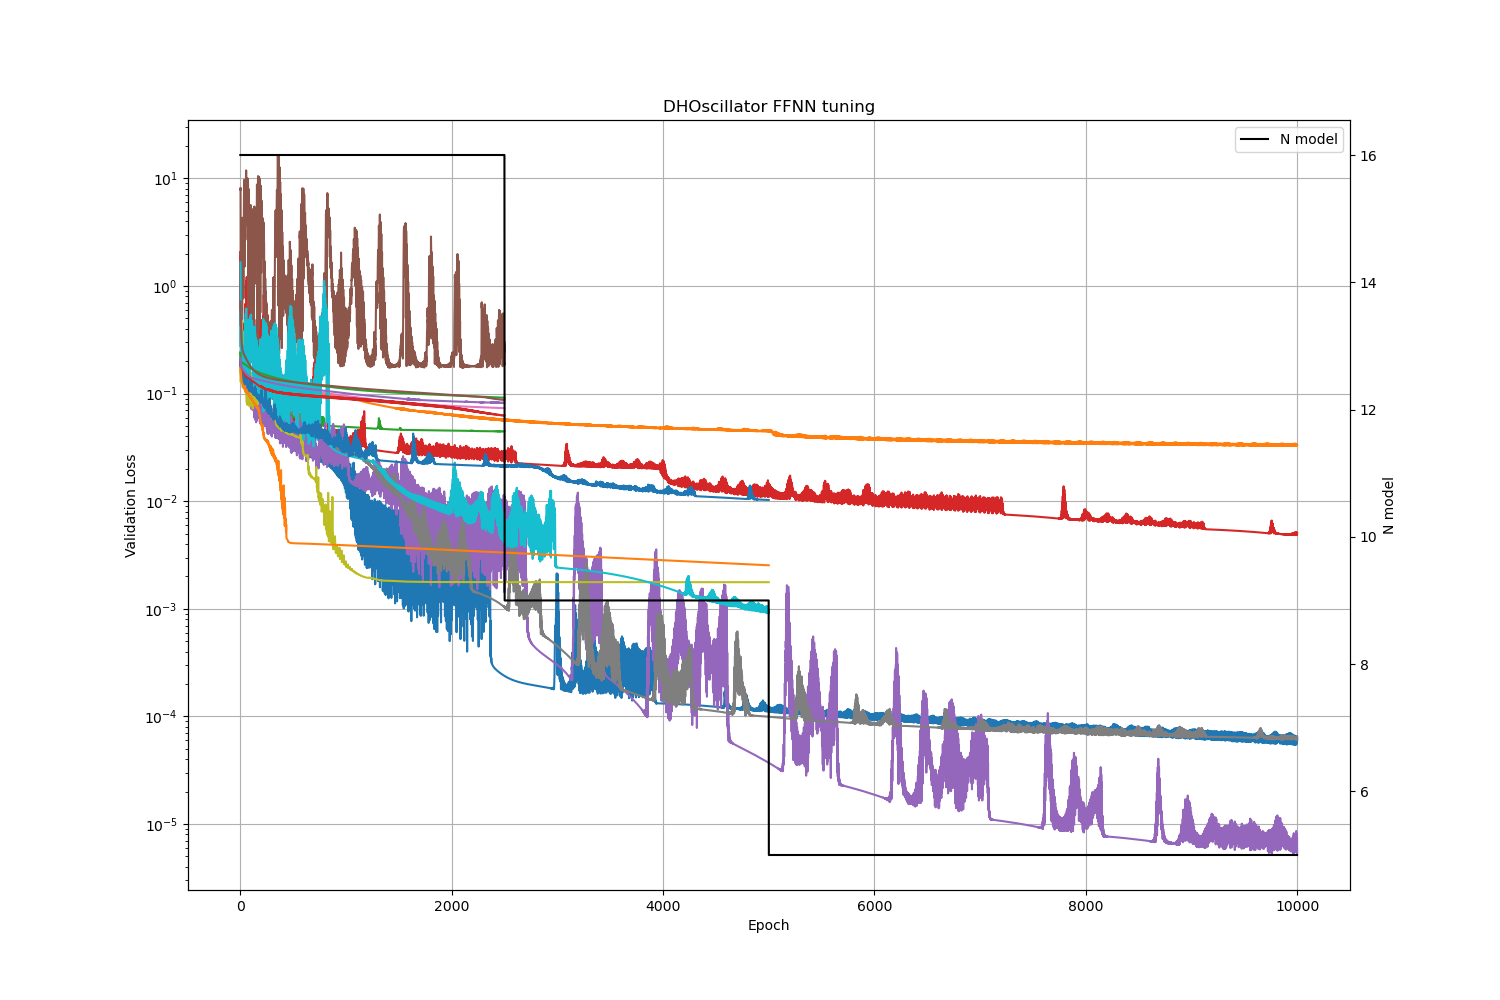

In [93]:
# show results
dfs = {result.path: result.metrics_dataframe for result in results}

# twinx plot alive_model and validation loss
fig, ax1 = plt.subplots(figsize=(15, 10))
# plot the validation loss
for path, df in dfs.items():
    ax1.plot(df["training_iteration"], df["loss"], label=path)
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.grid()

# plot the alive model
ax2 = ax1.twinx()
ax2.plot(alive_model, label="N model", color="black")
ax2.set_ylabel("N model")
ax2.legend()
ax2.grid()


plt.title("DHOscillator FFNN tuning")
plt.grid()

# save the plot
plt.savefig("../plot/DHOscillator_FFNN_tuning.png")


In [92]:
# get best model
best_result = results.get_best_result("loss", mode="min")
logdir = best_result.path
state_dict = torch.load(os.path.join(logdir, "model.pth"))
best_model = FFNN(best_result.config["n_layers"], best_result.config["n_neurons"])

best_model.load_state_dict(state_dict)

# save best model
torch.save(best_model, "../models/DHO_FFNN_tuned.pt")

In [52]:
# print validation and test loss
train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(
    data_X, 
    data_Y, 
    best_result.config["batch_size"]
    )


val_loss = torch.nn.MSELoss()(best_model(val_X), val_Y).item()
test_loss = torch.nn.MSELoss()(best_model(test_X), test_Y).item()

print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")


Validation Loss: 7.342151548073161e-06
Test Loss: 0.09691622108221054


## Restore results

In [95]:
# restore results
experiment_path = os.path.join(results_dir, "DHO_FFNN_tuning")
experiment_path

'/home/luigi/Documents/PHYSICS/ML/Project1/src/../tuning/DHO_FFNN_tuning'

In [96]:
restored_tuner = tune.Tuner.restore(experiment_path, objective)
restored_results = restored_tuner.get_results()

In [97]:
restored_df = restored_results.get_dataframe()
restored_df

loss   timestamp checkpoint_dir_name  done  training_iteration  \
0   0.001768  1710100758                None  True                5000   
1   0.062574  1710100664                None  True                2500   
2   0.082134  1710100684                None  True                2500   
3   0.087197  1710100661                None  True                2500   
4   0.091638  1710100641                None  True                2500   
5   0.000062  1710100604                None  True               10000   
6   0.073328  1710100440                None  True                2500   
7   0.000061  1710100674                None  True               10000   
8   0.002539  1710100802                None  True                5000   
9   0.044591  1710100405                None  True                2500   
10  0.005030  1710100603                None  True               10000   
11  0.000910  1710100546                None  True                5000   
12  0.033320  1710100583                None  True               10000   
13  0.010280  1710100568                None  True                5000   
14  0.188000  1710100414                None  True                2500   
15  0.000005  1710100634                None  True               10000   

       trial_id                 date  time_this_iter_s  time_total_s    pid  \
0   b6cbc_00008  2024-03-10_20-59-18          0.039083    294.712348  10493   
1   b6cbc_00013  2024-03-10_20-57-44          0.017209     50.915546  10491   
2   b6cbc_00014  2024-03-10_20-58-04          0.013014     59.925988  10494   
3   b6cbc_00015  2024-03-10_20-57-41          0.008908     30.493110  10525   
4   b6cbc_00012  2024-03-10_20-57-21          0.013911     37.032490  10497   
5   b6cbc_00007  2024-03-10_20-56-44          0.010854     89.195537  10525   
6   b6cbc_00006  2024-03-10_20-54-00          0.024073     48.955651  10497   
7   b6cbc_00000  2024-03-10_20-57-54          0.015730    169.932873  10459   
8   b6cbc_00011  2024-03-10_21-00-02          0.027495    225.069007  10496   
9   b6cbc_00002  2024-03-10_20-53-25          0.011742     18.122798  10493   
10  b6cbc_00003  2024-03-10_20-56-43          0.010067     84.705609  10494   
11  b6cbc_00009  2024-03-10_20-55-46          0.008236     44.852540  10496   
12  b6cbc_00001  2024-03-10_20-56-23          0.021216     65.895605  10491   
13  b6cbc_00010  2024-03-10_20-56-08          0.007587     41.369596  10497   
14  b6cbc_00005  2024-03-10_20-53-34          0.010947     26.572859  10496   
15  b6cbc_00004  2024-03-10_20-57-14          0.016839    120.658826  10495   

    ...         node_ip time_since_restore  iterations_since_restore  \
0   ...  192.168.50.220         294.712348                      5000   
1   ...  192.168.50.220          50.915546                      2500   
2   ...  192.168.50.220          59.925988                      2500   
3   ...  192.168.50.220          30.493110                      2500   
4   ...  192.168.50.220          37.032490                      2500   
5   ...  192.168.50.220          89.195537                     10000   
6   ...  192.168.50.220          48.955651                      2500   
7   ...  192.168.50.220         169.932873                     10000   
8   ...  192.168.50.220         225.069007                      5000   
9   ...  192.168.50.220          18.122798                      2500   
10  ...  192.168.50.220          84.705609                     10000   
11  ...  192.168.50.220          44.852540                      5000   
12  ...  192.168.50.220          65.895605                     10000   
13  ...  192.168.50.220          41.369596                      5000   
14  ...  192.168.50.220          26.572859                      2500   
15  ...  192.168.50.220         120.658826                     10000   

    config/n_layers  config/n_neurons  config/lr  config/factor  \
0                 4                26   0.026397       0.875736   
1                 4                18   0.0002